<a href="https://colab.research.google.com/github/HenryZumaeta/MDS_UNI/blob/Zeta/CICLO02/DL/C06_20240515_Transferencia_de_Aprendizaje_TensorFlow_Hub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Hub y transferencia de aprendizaje


[TensorFlow Hub](http://tensorflow.org/hub) es un repositorio en línea de modelos de TensorFlow ya entrenados que puedes usar.
Estos modelos se pueden utilizar tal cual o se pueden utilizar para el aprendizaje por transferencia.

El aprendizaje por transferencia es un proceso en el que se toma un modelo entrenado existente y se lo amplía para realizar trabajo adicional. Esto implica dejar la mayor parte del modelo sin cambios, mientras se agregan y reentrenan las capas finales, para obtener un conjunto diferente de posibles resultados.

En este Colab haremos ambas cosas.

Aquí puede ver todos los modelos disponibles en [TensorFlow Module Hub](https://tfhub.dev/).

## Conceptos que se cubrirán en este Colab

1. Utilice un modelo de TensorFlow Hub para la predicción.
2. Utilice un modelo de TensorFlow Hub para el conjunto de datos de perros frente a gatos.
3. Realice un aprendizaje por transferencia simple con TensorFlow Hub.

Antes de iniciar este Colab, debe restablecer el entorno de Colab seleccionando `Tiempo de ejecución -> Restablecer todos los tiempos de ejecución...` en el menú de arriba.

# Importar


Algunas importaciones normales que hemos visto antes. El nuevo importa tensorflow_hub que se instaló anteriormente y que este Colab hará un uso intensivo.

In [1]:
import tensorflow as tf
# Importa la biblioteca TensorFlow y le asigna el alias 'tf'


In [2]:
import matplotlib.pylab as plt
# Importa la biblioteca matplotlib para visualizaciones y le asigna el alias 'plt'

import tensorflow_hub as hub
# Importa la biblioteca tensorflow_hub para utilizar modelos pre-entrenados desde TensorFlow Hub

import tensorflow_datasets as tfds
# Importa la biblioteca tensorflow_datasets para acceder a conjuntos de datos incorporados y funciones de preprocesamiento

from tensorflow.keras import layers
# Importa el módulo 'layers' de la biblioteca Keras, que es parte de TensorFlow.
# Keras para construir y entrenar modelos de aprendizaje profundo.

In [3]:
import logging
 # Importa el módulo 'logging' para habilitar el registro de mensajes durante la ejecución del programa.

logger = tf.get_logger()
# Obtiene un objeto de registro específico de TensorFlow para registrar mensajes relacionados con TensorFlow.

logger.setLevel(logging.ERROR)
 # Establece el nivel de registro del objeto 'logger' a ERROR.

# Parte 1: Utilice TensorFlow Hub MobileNet para realizar predicciones

En esta parte de Colab, tomaremos un modelo entrenado, lo cargaremos en Keras y lo probaremos.

El modelo que usaremos es MobileNet v2 (pero cualquier modelo de [URL del clasificador de imágenes compatible con tf2 de tfhub.dev](https://tfhub.dev/s?q=tf2&module-type=image-classification) funcionaría). .

## Descargar el clasificador

Descargue el modelo MobileNet y cree un modelo Keras a partir de él.
MobileNet espera imágenes de 224 $\times$ 224 píxeles, en 3 canales de color (RGB).

In [4]:
CLASSIFIER_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])  # Crea un modelo secuencial de Keras. Utiliza una capa KerasLayer que carga un modelo preentrenado desde la URL especificada.
#La capa espera imágenes de tamaño (IMAGE_RES, IMAGE_RES, 3) como entrada, donde 3 representa los canales de color RGB.


MobileNet ha sido entrenado en el conjunto de datos de ImageNet. ImageNet tiene 1000 clases de salida diferentes, y una de ellas son los uniformes militares.
Obtengamos una imagen que contenga un uniforme militar que no sea parte de ImageNet y veamos si nuestro modelo puede predecir que es un uniforme militar.

61306/61306 [==============================] - 0s 0us/step


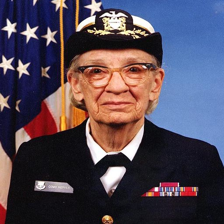

In [5]:
import numpy as np
# Importa la biblioteca NumPy para realizar operaciones numéricas y manipulación de arrays.

import PIL.Image as Image
 # Importa la clase Image del módulo PIL (Python Imaging Library) para trabajar con imágenes en Python.

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
 # Descarga la imagen de Grace Hopper desde la URL especificada y la guarda en un archivo local llamado 'image.jpg'. La función 'get_file' es una utilidad de TensorFlow para descargar archivos.

grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
  # Abre la imagen descargada y la redimensiona a las dimensiones especificadas por IMAGE_RES x IMAGE_RES. Esto es necesario para que coincida con el tamaño de entrada esperado por el modelo.

grace_hopper  # Muestra la imagen redimensionada de Grace Hopper. Este paso es comúnmente utilizado para verificar o visualizar los datos antes de procesarlos con modelos de aprendizaje automático.


In [6]:
grace_hopper = np.array(grace_hopper) / 255.0
 # Normaliza los valores de píxeles de la imagen dividiendo cada valor por 255.0, lo que escala los valores a un rango entre 0 y 1.
grace_hopper.shape  # Muestra la forma (shape) del array resultante. En este caso, la forma representa las dimensiones del array, que serán (IMAGE_RES, IMAGE_RES, 3) después de la normalización.
# El último valor 3 representa los canales de color (RGB) de la imagen.


(224, 224, 3)

Recuerde, los modelos siempre quieren procesar un lote de imágenes. Entonces, aquí agregamos una dimensión de lote y pasamos la imagen al modelo para su predicción.

In [7]:
result = model.predict(grace_hopper[np.newaxis, ...])  # Utiliza el modelo para hacer una predicción sobre la imagen
#de Grace Hopper después de expandir las dimensiones del array con np.newaxis.
# La expansión se realiza para que el modelo pueda aceptar un lote (batch) de imágenes como entrada, y no solo una imagen individual.

result.shape  # Muestra la forma (shape) del array resultante después de la predicción.
#La forma representa las dimensiones del array de salida del modelo, que generalmente es (1, NUM_CLASSES),
#donde NUM_CLASSES es el número de clases de la tarea de clasificación.
#En este contexto, el primer valor 1 indica que hay una sola imagen en el lote y el segundo valor representa las probabilidades de pertenencia a cada clase.


1/1 [==============================] - 4s 4s/step


(1, 1001)

El resultado es un vector de logits de 1001 elementos, que califica la probabilidad de cada clase para la imagen.

Entonces, el ID de clase superior se puede encontrar con argmax. Pero, ¿cómo podemos saber qué clase es realmente y, en particular, si esa identificación de clase en el conjunto de datos de ImageNet denota un uniforme militar o algo más?

In [8]:
predicted_class = np.argmax(result[0], axis=-1)  # Utiliza la función np.argmax para encontrar el índice
#del valor máximo en el array resultante. Esto determina la clase predicha para la imagen.

predicted_class  # Muestra la clase predicha para la imagen de Grace Hopper. El valor almacenado
#en 'predicted_class' es el índice de la clase con la probabilidad más alta, lo que indica la clase que el modelo predice para la imagen.


653

## Decodifica las predicciones

Para ver cuál es nuestra predicted_class en el conjunto de datos de ImageNet, descargue las etiquetas de ImageNet y busque la fila que predijo el modelo.

10484/10484 [==============================] - 0s 0us/step


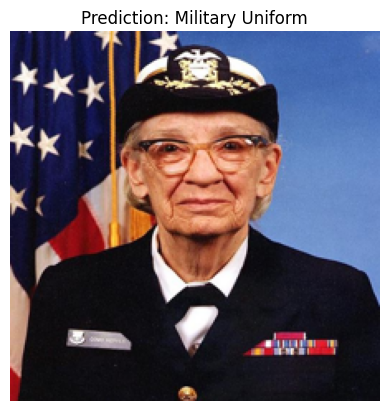

In [9]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
 # Descarga un archivo de texto que contiene las etiquetas de las clases de ImageNet y lo guarda en 'labels_path'.

imagenet_labels = np.array(open(labels_path).read().splitlines())
# Lee el contenido del archivo de etiquetas y crea un array de NumPy con las etiquetas de las clases.

plt.imshow(grace_hopper)
# Muestra la imagen de Grace Hopper en el gráfico.
plt.axis('off')
# Desactiva los ejes del gráfico para una mejor presentación visual.

predicted_class_name = imagenet_labels[predicted_class]
# Obtiene el nombre de la clase predicha a partir del array de etiquetas de ImageNet usando el índice de la clase predicha.

_ = plt.title("Prediction: " + predicted_class_name.title())
 # Establece el título del gráfico, indicando la clase predicha para la imagen de Grace Hopper.


Bingo. ¡Nuestro modelo predijo correctamente el uniforme militar!

# Parte 2: Utilice modelos de TensorFlow Hub para el conjunto de datos de gatos y perros

Ahora usaremos el modelo MobileNet completo y veremos cómo funciona en el conjunto de datos de Perros vs. Gatos.

## Conjunto de datos

Podemos usar TensorFlow Datasets para cargar el conjunto de datos Dogs vs Cats.

In [10]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs',  # Carga el conjunto de datos 'cats_vs_dogs' desde TensorFlow Datasets (TFDS).
    with_info=True,  # Incluye información adicional sobre el conjunto de datos, como el número de ejemplos y clases.
    as_supervised=True,  # Carga los datos en un formato (imagen, etiqueta) para facilitar el entrenamiento supervisado.
    split=['train[:80%]', 'train[80%:]'],  # Divide el conjunto de datos en un 80% para entrenamiento y un 20% para validación.
)

num_examples = info.splits['train'].num_examples  # Obtiene el número total de ejemplos en el conjunto de datos de entrenamiento.
num_classes = info.features['label'].num_classes  # Obtiene el número de clases en el conjunto de datos (en este caso, 2 para 'gatos' y 'perros').


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incompleteUIXZ6F/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


Las imágenes del conjunto de datos Perros vs. Gatos no son todas del mismo tamaño.

In [11]:
for i, example_image in enumerate(train_examples.take(3)):  # Itera sobre los primeros 3 ejemplos del conjunto de datos de entrenamiento.
    print("Image {} shape: {}".format(i+1, example_image[0].shape))  # Imprime la forma (shape) de cada imagen del conjunto de datos de entrenamiento.

# El bucle `for` recorre los primeros 3 ejemplos del conjunto de datos de entrenamiento (`train_examples`).
# Para cada ejemplo, imprime el número de imagen y su forma (shape), indicando las dimensiones de la imagen.


Image 1 shape: (262, 350, 3)
Image 2 shape: (409, 336, 3)
Image 3 shape: (493, 500, 3)


Por lo tanto, debemos reformatear todas las imágenes a la resolución esperada por MobileNet (224, 224).

Los `.repeat()` y `steps_per_epoch` aquí no son necesarios, pero ahorran ~15 s por época, ya que el shuffle-buffer solo tiene que iniciarse en frío una vez.

In [12]:
def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES)) / 255.0
     # Redimensiona la imagen a las dimensiones especificadas por IMAGE_RES x IMAGE_RES y
     #normaliza los valores de píxeles a un rango entre 0 y 1.
    return image, label  # Devuelve la imagen formateada y la etiqueta correspondiente.

BATCH_SIZE = 32  # Establece el tamaño del lote (batch size) para el entrenamiento y la validación.

train_batches = train_examples.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
 # Prepara lotes de entrenamiento: mezcla los ejemplos de entrenamiento, aplica el formato de imagen definido,
 #agrupa los ejemplos en lotes del tamaño especificado y los almacena en memoria para el acceso eficiente durante el entrenamiento.

validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)
 # Prepara lotes de validación: aplica el formato de imagen definido, agrupa los ejemplos en lotes del
 #tamaño especificado y los almacena en memoria para su uso durante la validación del modelo.

## Ejecute el clasificador en un lote de imágenes

Recuerde que nuestro objeto `model` sigue siendo el modelo MobileNet completo entrenado en ImageNet, por lo que tiene 1000 clases de salida posibles.
ImageNet tiene muchos perros y gatos, así que veamos si puede predecir las imágenes en nuestro conjunto de datos Perros vs. Gatos.

In [13]:
image_batch, label_batch = next(iter(train_batches.take(1)))
 # Obtiene un lote de imágenes y etiquetas del conjunto de datos de entrenamiento utilizando el iterador.
image_batch = image_batch.numpy()
# Convierte el lote de imágenes a un array de NumPy para su manipulación.
label_batch = label_batch.numpy()
 # Convierte el lote de etiquetas a un array de NumPy para su manipulación.

result_batch = model.predict(image_batch)
# Utiliza el modelo para hacer predicciones sobre el lote de imágenes y obtiene las probabilidades de pertenencia a cada clase.

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
 # Obtiene los nombres de las clases predichas para el lote de imágenes.
predicted_class_names  # Muestra los nombres de las clases predichas para el lote de imágenes.

# Los nombres de las clases predichas se almacenan en 'predicted_class_names' para su inspección.


1/1 [==============================] - 2s 2s/step


array(['file', 'computer keyboard', 'Saluki', 'English setter',
       'tiger cat', 'kelpie', 'Labrador retriever', 'cairn', 'Great Dane',
       'Persian cat', 'Persian cat', 'cocker spaniel', 'tabby', 'carton',
       'tabby', 'German shepherd', 'tabby', 'papillon', 'Cardigan',
       'tiger cat', 'Chesapeake Bay retriever', 'Cardigan',
       'Egyptian cat', 'kelpie', 'tabby', 'schipperke',
       'Labrador retriever', 'tabby', 'Border terrier',
       'Rhodesian ridgeback', 'cocker spaniel', 'toy terrier'],
      dtype='<U30')

Las etiquetas parecen coincidir con nombres de perros y gatos. Ahora tracemos las imágenes de nuestro conjunto de datos Dogs vs Cats y coloquemos las etiquetas de ImageNet junto a ellas.

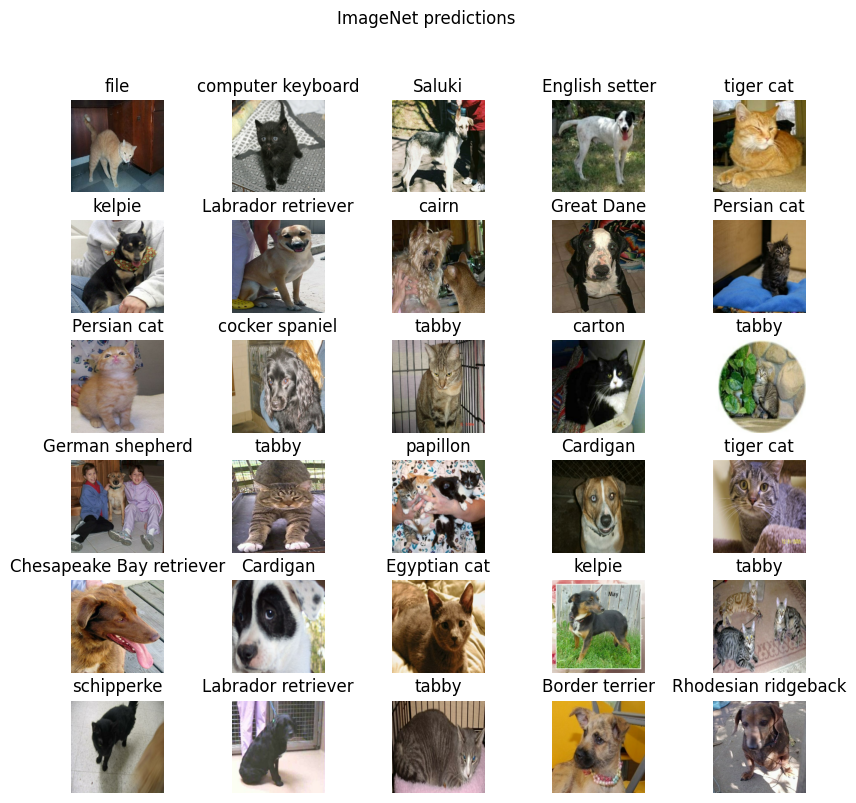

In [14]:
plt.figure(figsize=(10,9))
# Establece el tamaño de la figura para mostrar las imágenes y las predicciones.

for n in range(30):  # Itera sobre los primeros 30 ejemplos del lote de imágenes.
    plt.subplot(6, 5, n+1)  # Crea subtramas en una cuadrícula de 6 filas y 5 columnas.
    plt.subplots_adjust(hspace=0.3)  # Ajusta el espaciado vertical entre las subtramas.

    plt.imshow(image_batch[n])  # Muestra la imagen en la subtrama actual.
    plt.title(predicted_class_names[n])  # Establece el título de la subtrama con la clase predicha para la imagen.
    plt.axis('off')  # Desactiva los ejes para una mejor presentación visual.

_ = plt.suptitle("ImageNet predictions")  # Establece el título principal de la figura.

# En este bloque de código, se crea una figura que muestra las primeras
# 30 imágenes del lote junto con las clases predichas para cada imagen.
# Cada subtrama contiene una imagen y su clase predicha, y
#el título principal de la figura indica que son predicciones de ImageNet.


# Parte 3: Realice un aprendizaje por transferencia simple con TensorFlow Hub

Ahora usemos TensorFlow Hub para realizar Transfer Learning.

Con el aprendizaje por transferencia reutilizamos partes de un modelo ya entrenado y cambiamos la capa final, o varias capas, del modelo, y luego volvemos a entrenar esas capas en nuestro propio conjunto de datos.

Además de los modelos completos, TensorFlow Hub también distribuye modelos sin la última capa de clasificación. Estos se pueden utilizar para transferir fácilmente el aprendizaje. Continuaremos usando MobileNet v2 porque en partes posteriores de este curso tomaremos este modelo y lo implementaremos en un dispositivo móvil usando [TensorFlow Lite] (https://www.tensorflow.org/lite). Cualquier [URL de vector de característica de imagen de tfhub.dev](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) funcionaría aquí.

También continuaremos usando el conjunto de datos Perros vs Gatos, por lo que podremos comparar el rendimiento de este modelo con los que creamos desde cero anteriormente.

Tenga en cuenta que llamamos al modelo parcial de TensorFlow Hub (sin la capa de clasificación final) "feature_extractor". El razonamiento de este término es que llevará la entrada hasta una capa que contiene varias características. Por lo tanto, ha realizado la mayor parte del trabajo para identificar el contenido de una imagen, excepto crear la distribución de probabilidad final. Es decir, ha extraído las características de la imagen.

In [15]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
 # Especifica la URL del modelo de extracción de características de MobileNetV2 en TensorFlow Hub.

feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
# Crea una capa de extracción de características utilizando el modelo preentrenado de MobileNetV2 desde la URL especificada.
# La capa está configurada para aceptar imágenes de tamaño (IMAGE_RES, IMAGE_RES, 3) como entrada, donde 3 representa los canales de color RGB.


Pasemos un lote de imágenes a través de esto y veamos la forma final. 32 es el número de imágenes y 1280 es el número de neuronas en la última capa del modelo parcial de TensorFlow Hub.

In [16]:
feature_batch = feature_extractor(image_batch)  # Utiliza la capa de extracción de características para procesar el lote de imágenes.

print(feature_batch.shape)  # Imprime la forma (shape) del array resultante después de la extracción de características.

# En este bloque de código, se utiliza la capa de extracción de características para procesar el lote de imágenes del conjunto de datos de entrenamiento.
# La forma del array resultante se imprime para mostrar las dimensiones de las características extraídas.


(32, 1280)


Congele las variables en la capa del extractor de características, de modo que el entrenamiento solo modifique la capa del clasificador final.

In [17]:
feature_extractor.trainable = False
# Establece el atributo 'trainable' de la capa de extracción de características en False.


## Adjunte un encabezado de clasificación

Ahora envuelva la capa central en un modelo `tf.keras.Sequential` y agregue una nueva capa de clasificación.

In [18]:
model = tf.keras.Sequential([
    feature_extractor,  # Agrega la capa de extracción de características (MobileNetV2) al modelo.
    layers.Dense(2)  # Agrega una capa densa con 2 unidades para la clasificación binaria de 'gatos' y 'perros'.
])

model.summary()
 # Muestra un resumen del modelo, incluyendo la arquitectura de las capas y el número de parámetros entrenables.

# En este bloque de código, se crea un modelo secuencial de Keras que consiste en la capa de extracción de características (
    #MobileNetV2) seguida de una capa densa con 2 unidades para la clasificación binaria de 'gatos' y 'perros'.
# El método 'summary()' muestra una descripción detallada de la arquitectura del modelo y el número de parámetros.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


## Entrena el modelo

Ahora entrenamos este modelo como cualquier otro, llamando primero a `compile` y luego a `fit`.

In [19]:
model.compile(
    optimizer='adam',  # Configura el optimizador Adam para el entrenamiento del modelo.
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # Utiliza la entropía cruzada categórica como función de pérdida para problemas de clasificación.
    metrics=['accuracy']  # Utiliza la Exactitud como métrica para evaluar el rendimiento del modelo durante el entrenamiento.
)

EPOCHS = 5  # Establece el número de épocas para entrenar el modelo.

history = model.fit(
    train_batches,  # Utiliza el lote de entrenamiento para el entrenamiento del modelo.
    epochs=EPOCHS,  # Número de épocas para entrenar el modelo.
    validation_data=validation_batches  # Utiliza el lote de validación para evaluar el modelo después de cada época de entrenamiento.
)


Epoch 1/5
582/582 [==============================] - 49s 65ms/step - loss: 0.0546 - accuracy: 0.9811 - val_loss: 0.0327 - val_accuracy: 0.9890
Epoch 2/5
582/582 [==============================] - 43s 64ms/step - loss: 0.0304 - accuracy: 0.9889 - val_loss: 0.0407 - val_accuracy: 0.9856
Epoch 3/5
582/582 [==============================] - 43s 62ms/step - loss: 0.0253 - accuracy: 0.9913 - val_loss: 0.0327 - val_accuracy: 0.9890
Epoch 4/5
582/582 [==============================] - 44s 62ms/step - loss: 0.0214 - accuracy: 0.9925 - val_loss: 0.0348 - val_accuracy: 0.9888
Epoch 5/5
582/582 [==============================] - 39s 55ms/step - loss: 0.0196 - accuracy: 0.9935 - val_loss: 0.0388 - val_accuracy: 0.9884


Puede ver que obtenemos una precisión de validación de ~99%, lo cual es absolutamente asombroso. Esta es una gran mejora con respecto al modelo que creamos en la lección anterior, donde pudimos obtener ~99% de precisión. La razón de esta diferencia es que MobileNet fue diseñado cuidadosamente durante mucho tiempo por expertos y luego entrenado en un conjunto de datos masivo (ImageNet).

Aunque no es equivalente a TensorFlow Hub, puede consultar cómo crear MobileNet en Keras [aquí](https://github.com/keras-team/keras-applications/blob/master/keras_applications/mobilenet.py).

Tracemos los gráficos de precisión/pérdida de entrenamiento y validación.

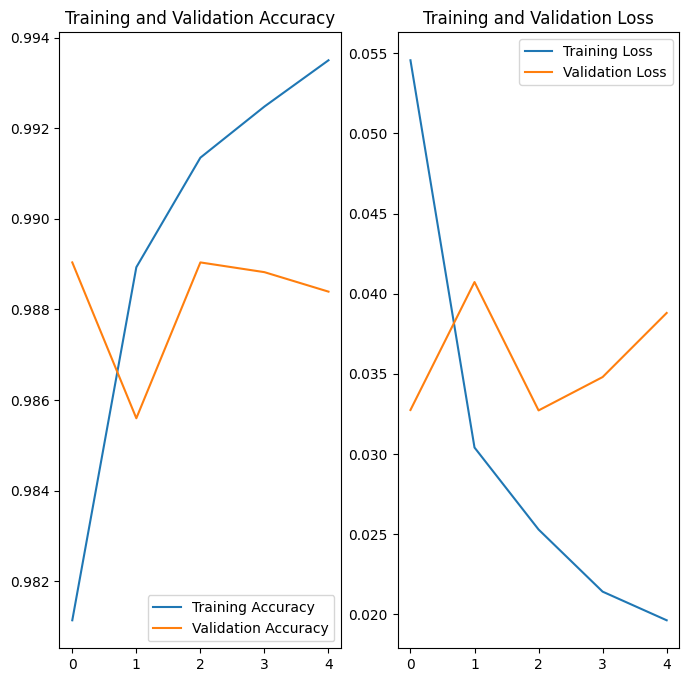

In [20]:
acc = history.history['accuracy']  # Obtiene la precisión del entrenamiento en cada época.
val_acc = history.history['val_accuracy']  # Obtiene la precisión de la validación en cada época.

loss = history.history['loss']  # Obtiene la pérdida del entrenamiento en cada época.
val_loss = history.history['val_loss']  # Obtiene la pérdida de la validación en cada época.

epochs_range = range(EPOCHS)  # Crea un rango de épocas para utilizar en el gráfico.

plt.figure(figsize=(8, 8))  # Establece el tamaño de la figura para mostrar las gráficas de precisión y pérdida.

# Gráfico de precisión del entrenamiento y validación.
plt.subplot(1, 2, 1)  # Crea una subtrama en la primera posición de una cuadrícula de 1 fila y 2 columnas.
plt.plot(epochs_range, acc, label='Training Accuracy')  # Dibuja la precisión del entrenamiento.
plt.plot(epochs_range, val_acc, label='Validation Accuracy')  # Dibuja la precisión de la validación.
plt.legend(loc='lower right')  # Muestra la leyenda en la esquina inferior derecha.
plt.title('Training and Validation Accuracy')  # Establece el título del gráfico.

# Gráfico de pérdida del entrenamiento y validación.
plt.subplot(1, 2, 2)  # Crea una subtrama en la segunda posición de la cuadrícula.
plt.plot(epochs_range, loss, label='Training Loss')  # Dibuja la pérdida del entrenamiento.
plt.plot(epochs_range, val_loss, label='Validation Loss')  # Dibuja la pérdida de la validación.
plt.legend(loc='upper right')  # Muestra la leyenda en la esquina superior derecha.
plt.title('Training and Validation Loss')  # Establece el título del gráfico.

plt.show()  # Muestra los gráficos de precisión y pérdida.

# En este bloque de código, se generan y muestran gráficas que representan la precisión y pérdida del modelo durante el entrenamiento y la validación.


Lo que resulta un poco curioso aquí es que el rendimiento de la validación es mejor que el rendimiento del entrenamiento, desde el principio hasta el final de la ejecución.

Una razón para esto es que el rendimiento de la validación se mide al final de la época, pero el rendimiento del entrenamiento son los valores promedio a lo largo de la época.

Sin embargo, la razón más importante es que estamos reutilizando una gran parte de MobileNet que ya está entrenado en imágenes de perros y gatos. Mientras se realiza el entrenamiento, la red sigue realizando un aumento de imágenes en las imágenes de entrenamiento, pero no en el conjunto de datos de validación. Esto significa que las imágenes de entrenamiento pueden ser más difíciles de clasificar en comparación con las imágenes normales del conjunto de datos de validación.

## Consulta las predicciones

Para rehacer la trama anterior, primero obtenga la lista ordenada de nombres de clases.

In [21]:
class_names = np.array(info.features['label'].names)
class_names
# Obtiene y muestra las etiquetas de clase del conjunto de datos. En este caso,
#las etiquetas son 'gato' y 'perro', y se almacenan en el array 'class_names'.

array(['cat', 'dog'], dtype='<U3')

Ejecute el lote de imágenes a través del modelo y convierta los índices en nombres de clases.

In [22]:
predicted_batch = model.predict(image_batch)
 # Realiza predicciones sobre el lote de imágenes utilizando el modelo entrenado.
predicted_batch = tf.squeeze(predicted_batch).numpy()
# Elimina las dimensiones adicionales del array resultante y lo convierte a un array de NumPy.
predicted_ids = np.argmax(predicted_batch, axis=-1)
# Obtiene los índices de las clases predichas para cada imagen.
predicted_class_names = class_names[predicted_ids]
 # Obtiene los nombres de las clases predichas a partir de los índices utilizando las etiquetas del conjunto de datos.

predicted_class_names
# Muestra los nombres de las clases predichas para el lote de imágenes del conjunto de datos de entrenamiento.


1/1 [==============================] - 0s 427ms/step


array(['cat', 'cat', 'dog', 'dog', 'cat', 'dog', 'dog', 'dog', 'dog',
       'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'cat', 'cat',
       'dog', 'cat', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'dog',
       'cat', 'dog', 'dog', 'dog', 'dog'], dtype='<U3')

Veamos las etiquetas verdaderas y las previstas.

In [23]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)
# Imprime las etiquetas reales (ground truth) del lote de imágenes (label_batch) y
# las etiquetas predichas por el modelo (predicted_ids).

Labels:  [0 0 1 1 0 1 1 1 1 0 0 1 0 0 0 1 0 0 1 0 1 1 0 1 0 0 1 0 1 1 1 1]
Predicted labels:  [0 0 1 1 0 1 1 1 1 0 0 1 0 0 0 1 0 0 1 0 1 1 0 1 0 0 1 0 1 1 1 1]


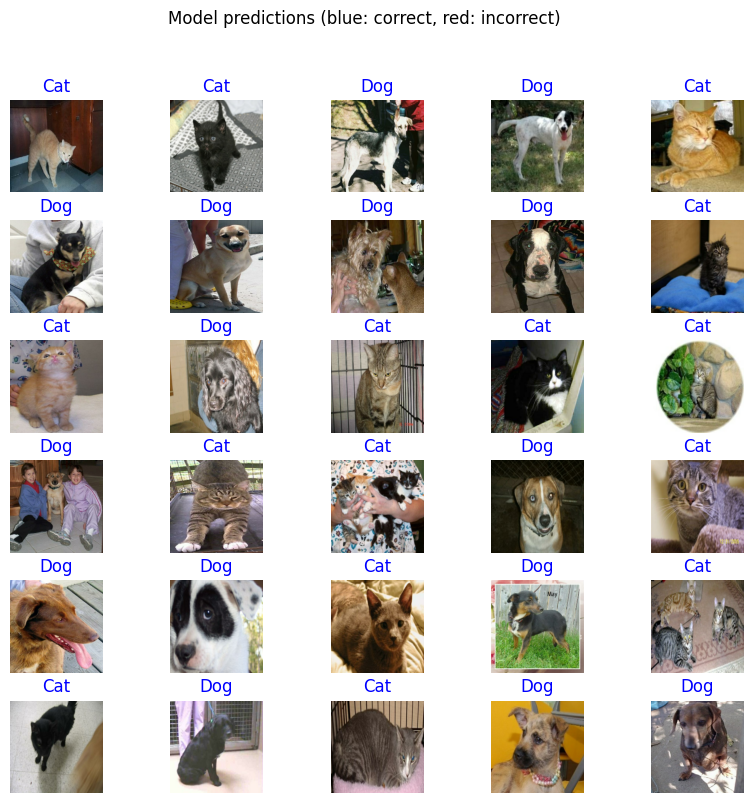

In [24]:
plt.figure(figsize=(10,9))  # Establece el tamaño de la figura para mostrar las imágenes y las predicciones.

for n in range(30):  # Itera sobre los primeros 30 ejemplos del lote de imágenes.
    plt.subplot(6, 5, n+1)  # Crea subtramas en una cuadrícula de 6 filas y 5 columnas.
    plt.subplots_adjust(hspace=0.3)  # Ajusta el espaciado vertical entre las subtramas.

    plt.imshow(image_batch[n])  # Muestra la imagen en la subtrama actual.
    color = "blue" if predicted_ids[n] == label_batch[n] else "red"  # Determina el color del título según si la predicción es correcta o incorrecta.
    plt.title(predicted_class_names[n].title(), color=color)  # Establece el título de la subtrama con la clase predicha para la imagen, resaltando las predicciones incorrectas en rojo.
    plt.axis('off')  # Desactiva los ejes para una mejor presentación visual.

_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")  # Establece el título principal de la figura para indicar las predicciones del modelo y resaltar las predicciones incorrectas en rojo.
